In [2]:
import numpy as np
import cv2
import sys
import matplotlib.pyplot as plt
import gc
import os
from tqdm.notebook import tqdm
from pathlib import Path
import pandas as pd
from matplotlib.patches import Polygon
from collections import Counter
import statistics

from math import floor
from decimal import Decimal, ROUND_HALF_UP
import pprint

from PatientClass import cut

%matplotlib inline
plt.gray()

<Figure size 432x288 with 0 Axes>

## ユーティリティ

In [3]:
#画像の表示

def imgshow(img):
    cv2.namedWindow('image', cv2.WINDOW_NORMAL)
    cv2.imshow('image',img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

def imgplot(img):
    if len(img.shape) == 3:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(img)
    plt.show()
    
def grayscale(img):
    return np.uint8(cv2.cvtColor(img,cv2.COLOR_BGR2GRAY))

In [4]:
# 孤立しているピクセルを取り除く
def clean_image(img):
    m,n = img.shape
    for i in range(1,m-1):
            for j in range(1,n-1):
                if (img[i,j] > 0 and img[i,j-1] == 0 and img[i,j+1] == 0 and img[i-1,j-1] == 0
                and img[i-1,j+1] == 0 and img[i+1,j-1] == 0 and img[i+1,j+1] == 0):
                    img[i,j] = 0
    return img

In [5]:
# 画像の読み込み及び辞書の作成
def make_image_dic(image_namelist):
    image_dic = {}
    for i in image_namelist:
        img0 = cv2.imread(str(i))
        print(i.stem,':',img0.shape)
        image_dic[i.stem] = img0
    return image_dic

def image_to_name(img,annotated_image_dic,return_name):
    image_name = [k for k, v in annotated_image_dic.items() if (v == img).all()]
    if return_name == True:
        return image_name[0]
    else:
        print('image_name:',image_name[0])

def annotated_to_image(img,annotated_image_dic,image_dic):
    annotated_image_name = image_to_name(img,annotated_image_dic,True)
    image_name = annotated_image_name.replace('annotated','')
    img0 = image_dic[image_name]
    return img0

In [6]:
#整数かどうかの判定
def is_integer_num(n):
    if isinstance(n, int):
        return 1
    if isinstance(n, float):
        if n.is_integer() == True:
            return 1
        else: return 0
    return False

## スキーマの作成及び外接矩形の算出

In [22]:
#エコー画像からスキーマ部分の特定
def thyroid_detect(img):
    img_gray = np.uint8(cv2.cvtColor(img,cv2.COLOR_BGR2GRAY))
    imgplot(img_gray)
    
#edge
    c = cv2.Canny(img_gray,750,800)
    imgplot(c)
    
#フィルタ
    kernel = np.ones((50,50),np.float32)/500
    dst = cv2.filter2D(c,-1,kernel,borderType = cv2.BORDER_WRAP)
    imgplot(dst)

#中心を特定
    ct = np.int32(np.mean(np.where(dst==np.max(dst)),axis=-1))
    print('ct:',ct)
    
    return dst,ct

#エコー画像からスキーマ部分の切り出し
def thyroid_trim(img,dst,ct):
    t,b,l,r = 0,0,0,0
    s = 0
    while(s<4):
        s = 0
        if  dst[ct[0]-t,ct[1]] >= 85:
            t += 1
        else:
            s += 1
        if  dst.shape[0]>ct[0]+b and dst[ct[0]+b,ct[1]] >= 88:
            b += 1
        else:
            s += 1
        if  dst[ct[0],ct[1]-l] >= 88:
            l += 1
        else:
            s += 1
        if  dst.shape[1]>ct[1]+r and dst[ct[0],ct[1]+r] >= 88:
            r += 1
        else:
            s += 1

    #print('t:',t,',b:',b,',l:',l,',r',r)
    print('[{}:{},{}:{}]'.format(ct[0]-t,ct[0]+b,ct[1]-l,ct[1]+r))
    sc = img[ct[0]-t:ct[0]+b,ct[1]-l:ct[1]+r].copy()
    print('sc:')
    imgplot(sc)
    
    sc0 = np.uint8(cv2.cvtColor(sc,cv2.COLOR_BGR2GRAY))
    sc0[sc0<100] = 0
    sc[sc0==0] = 0
    print('sc0')
    imgplot(sc0)
    print('sc')
    imgplot(sc)
    
    return sc,[t,b,l,r]

In [8]:
#スキーマ→プローブの抽出
def probe_detect(sc):
    m,n,d = sc.shape
    sh = np.uint8(np.zeros((sc.shape[0],sc.shape[1])))

    for i in range(m):
        for j in range(n):
            b,g,r = sc[i,j]
            if (150 <= r and 80 <= g and g <= 190 and b <=110 and g > b) or (r<220 and r<b-15 and r<g-10):
                sh[i,j] = 255
    print('sh:')
    imgplot(sh)
    
    if np.max(sh.sum(axis=0)) > np.max(sh.sum(axis=1)):
        direction = 'vertical'
    else: direction = 'horizonal'
    print(direction)
    return sh, direction

In [9]:
#スキーマの甲状腺の中心の列方向の座標，プローブの座標計算
def thyroid_measure(sc,sh,direction):
    dmin = 100
    cmax = int(sc.shape[1]/2)-5

    sc0 = np.uint8(cv2.cvtColor(sc,cv2.COLOR_BGR2GRAY))
    sc0[sh>0] = 0
    
    #ノイズを除去
    #m,n = sc0.shape 
    #sc0 = np.where(sc0<10,0,sc0)
    #for i in range(1,m-1):
    #        for j in range(1,n-1):
    #            if (sc0[i,j] > 0 and sc0[i,j-1] == 0 and sc0[i,j+1] == 0 and sc0[i-1,j-1] == 0
    #            and sc0[i-1,j+1] == 0 and sc0[i+1,j-1] == 0 and sc0[i+1,j+1] == 0):
    #                sc0[i,j] = 0
    
    
    sc_copy = sc.copy()

    print('sc0')
    imgplot(sc0)
    print(sc0.shape)

    for i in range(int(sc.shape[1]/2)-5,int(sc.shape[1]/2)+6):
        col = len(sc0[:,i])

        p = 0
        n = 0
        j = 10
        while j<col:
            #print(i,' ',j,' ',sc0[j,i],' ',sc0[j-2,i],' ',p,' ',n,' ',cmax,' ',dmin)
        
            if (sc0[j,i] > 120) and (sc0[j-2,i] < 36) :
                n += 1
                if n == 2:
                    p = j
                elif n==3:
                    if j-p < dmin:
                        dmin = j-p
                        cmax = i
                    #print('break ',i,' ',j,' ',sc0[j,i],' ',sc0[j-2,i],' ',p,' ',n,' ',cmax,' ',dmin,' ',j-p)
                    break
                j += 3
            j += 1
    
    sc_copy[:,cmax] = [200,100,50]
    
    sh_1 = sh.copy()
    sh_1_m, sh_1_n = sh_1.shape    
    sh_1 = clean_image(sh_1)

    
    if direction =='vertical':
        cd = np.argmax(sh.sum(axis=0))
        print('cd:',cd)
        th_min, th_max = probe_measure(sh, cd, direction)
        for i in range(sh_1_m):
            for j in range(sh_1_n):
                if sh_1[i,j] > 0 and (i < th_min or i > th_max):
                    sh_1[i,j] = 0
        
        col_list = np.count_nonzero(sh_1 > 0,axis=0)
        col_max = max(col_list)

        col_num_list = []
        for i,col_len in enumerate(col_list):
            if i == 0:
                if col_len > 0.6 * col_max and col_list[i+1] > 0.6 * col_max:
                    col_num_list.append(i)
            elif i == len(col_list) - 1:
                if col_len > 0.6 * col_max and col_list[i-1] > 0.6 * col_max:
                    col_num_list.append(i)
            else:
                if col_len > 0.6 * col_max and (col_list[i-1]> 0.6 * col_max or col_list[i+1] > 0.6 * col_max):
                    col_num_list.append(i)
        cd = int(statistics.median(col_num_list))
        sc_copy[:,cd] = [50,200,50]
        
    elif direction == 'horizonal':
        cd = np.argmax(sh.sum(axis=1))
        th_min, th_max = probe_measure(sh, cd, direction)
        
        for i in range(sh_1_m):
            for j in range(sh_1_n):
                if sh_1[i,j] > 0 and (j < th_min or j > th_max):
                    sh_1[i,j] = 0

        row_list = np.count_nonzero(sh_1 > 0,axis=1)
        row_max = max(row_list)
        row_num_list = []
        for i,row_len in enumerate(row_list):
            if i == 0:
                if row_len > 0.6 * row_max and row_list[i+1] > 0.6 * row_max:
                    row_num_list.append(i)
                    print(i,row_len)
            elif i == len(row_list) - 1:
                if row_len > 0.6 * row_max and row_list[i-1] > 0.6 * row_max:
                    row_num_list.append(i)
            else:
                if row_len > 0.6 * row_max and (row_list[i-1]> 0.6 * row_max or row_list[i+1] > 0.6 * row_max):
                    row_num_list.append(i)
        
        cd = int(statistics.median(row_num_list))     
        sc_copy[cd,:] = [50,200,50]
    
    print('sc_copy')
    imgplot(sc_copy)
    return cmax, cd

#プローブの残りの座標計算
def probe_measure(sh,cd,derection):
    sh = clean_image(sh)
    if derection== 'vertical':
        sh_hot = sh[:,cd]
    elif derection=='horizonal':
        sh_hot = sh[cd,:]
#thyroidのcol
    th_max = 0
    th_min = 0
    for (i, x) in enumerate(sh_hot):
        if x>0 and th_min==0:
            th_min = i
        elif x==0 and th_min>0 and th_max==0:
            th_max = i-1
    return th_min, th_max

In [10]:
#スキーマからプローブを削除，ノイズを除去
def clean_schema(sc,sh,direction):
#探索用甲状腺画像を作成
    sc1 = np.uint8(cv2.cvtColor(sc,cv2.COLOR_BGR2GRAY))
    sc1[sh>0] = 0
    #imgplot(sc1)
    m,n = sc1.shape
    
    
    #ノイズを除去
    m,n = sc1.shape 
    sc1 = np.where(sc1<10,0,sc1)
    for i in range(1,m-1):
            for j in range(1,n-1):
                if (sc1[i,j] > 0 and sc1[i,j-1] == 0 and sc1[i,j+1] == 0 and sc1[i-1,j-1] == 0
                and sc1[i-1,j+1] == 0 and sc1[i+1,j-1] == 0 and sc1[i+1,j+1] == 0):
                    sc1[i,j] = 0
    
    # 縦方向にエコーを見ていた場合の線の残りを消去
    if direction =='vertical':
        for i in range(1,m-1):
            for j in range(1,n-1):
                if (sc1[i,j] > 20 and sc1[i,j-1] < 20 and sc1[i,j+1] < 20 and sc1[i-1,j-1] < 20
                and sc1[i-1,j+1] < 20 and sc1[i+1,j-1] < 20 and sc1[i+1,j+1] < 20):
                    sc1[i,j] = 0
                
    #画像の端にあるノイズを削除
    #縦
    for i in range(m):
        if sc1[i,0]>20 and sc1[i,1]<20:
            sc1[i,0] = 0
        elif sc1[i,n-1]>20 and sc1[i,n-2]<20:
            sc1[i,n-1] = 0

    #横
    for i in range(n):
        if sc1[0,i]>20 and sc1[1,i]<20:
            sc1[0,i] = 0
        elif sc1[m-1,i]>20 and sc1[m-2,i]<20:
            sc1[m-1,i] = 0
    print('sc1:')
    imgplot(sc1)
    return sc1

'''
elif direction == 'horizonal':
    for i in range(1,m-1):
        for j in range(n):
            if sc1[i,j] > 20 and sc1[i-1,j] < 10 and sc1[i-1,j] < 10:
                sc1[i,j] = 0    
''' 

"\nelif direction == 'horizonal':\n    for i in range(1,m-1):\n        for j in range(n):\n            if sc1[i,j] > 20 and sc1[i-1,j] < 10 and sc1[i-1,j] < 10:\n                sc1[i,j] = 0    \n"

In [11]:
#スキーマから不要な部分を削除
def remove_neck(sc1,cmax):
    #上側の消去
    m_sc1,n_sc1 = sc1.shape
    ur_temp = sc1[:,cmax]

    n=0
    neck=0
    cen_row_max = 0
    cen_row_min = 0

    for (i, x) in enumerate(ur_temp):
        if x>=30 and n==0:
            n+=1
            neck = i
        elif x>=30 and n==1:
            neck = i
        elif x<30 and n==1:
            n+=1
        elif x>=100 and n==2 and cen_row_min==0:
            cen_row_min = i
            n+=1
        elif x<100 and n==3:
            n+=1
        elif x>=100 and n==4:
            n+=1
            cen_row_max = i
        elif x>=100 and n==5:
            cen_row_max = i

    sc2 = sc1.copy()
    sc2[:neck+1,:]=0

    #左右の探索
    left = 0
    right = n_sc1

    ur_copy = sc2.copy()
    
    ur_copy[cen_row_min:,] = 0
    ur_temp = np.count_nonzero(ur_copy > 20, axis = 0)
    n = 0
    for (i, x) in enumerate(ur_temp):
        if x > 0 and n == 0:
            n = 1
            left = i
        elif x > 0 and n == 1:
            left = i
        elif x == 0 and n == 1:
            n += 1
            break


    n = 0
    for (i, x) in enumerate(reversed(ur_temp)):
        if x > 0 and n == 0:
            n = 1
            right = n_sc1 - 1-i
        elif x > 0 and n == 1:
            right = n_sc1 - 1-i
        elif x == 0 and n == 1:
            n += 1
            break

    sc2[:,:left+1]=0
    sc2[:,right:]=0

    #下の探索
    bottom=0

    n=0
    for j in range(n_sc1):
        ur_temp = sc2[:,j]
        for (i, x) in enumerate(ur_temp):
            if x>=30 and n==0:
                bottom = i
                break

    sc2[bottom:,:]=0


    #ノイズを除去
    sc2 = np.where(sc2<10,0,sc2)
    for i in range(1,m_sc1-1):
            for j in range(1,n_sc1-1):
                if (sc2[i,j] > 0 and sc2[i,j-1] == 0 and sc2[i,j+1] == 0 and sc2[i-1,j-1] == 0
                and sc2[i-1,j+1] == 0 and sc2[i+1,j-1] == 0 and sc2[i+1,j+1] == 0):
                    sc2[i,j] = 0

    print('sc2')
    imgplot(sc2)
    
    return cen_row_min,cen_row_max,sc2

In [12]:
#輪郭描写
def draw_contours(ax, img, contours):
    ax.imshow(img)  # 画像を表示する。
    ax.set_axis_off()

    for i, cnt in enumerate(contours):
        # 形状を変更する。(NumPoints, 1, 2) -> (NumPoints, 2)
        cnt = cnt.squeeze(axis=1)
        # 輪郭の点同士を結ぶ線を描画する。
        ax.add_patch(Polygon(cnt, color="b", fill=None, lw=2))
        # 輪郭の点を描画する。
        ax.plot(cnt[:, 0], cnt[:, 1], "ro", mew=0, ms=4)
        # 輪郭の番号を描画する。
        ax.text(cnt[0][0], cnt[0][1], i, color="orange", size="20")

In [13]:
#外接矩形の座標計算
def make_boundingRect(sc2):
    contours, hierarchy = cv2.findContours(sc2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    print("{} contours.".format(len(contours)))

    fig, ax = plt.subplots(figsize=(8, 8))
    draw_contours(ax, sc2, contours)
    plt.show()
    
    contours.sort(key=cv2.contourArea, reverse=True)
    
    cnt = contours[0]
    x,y,w,h = cv2.boundingRect(cnt)
    
    if len(contours) > 1:
        cnt_list = [cnt]
        x2 = x + w
        y2 = y + h
        
        for cnt_i in contours[1:]:
            if cv2.contourArea(cnt) * 0.2 <= cv2.contourArea(cnt_i):
                x_temp,y_temp,w_temp,h_temp = cv2.boundingRect(cnt_i)
                x2_temp = x_temp + w_temp
                y2_temp = y_temp + h_temp
            
                x = min(x,x_temp)
                y = min(y,y_temp)
                x2 = max(x2,x2_temp)
                y2 = max(y2,y2_temp)

        w = x2 - x
        h = y2 - y
    
    return x,y,w,h

## アノテーションデータの処理

In [14]:
#色を基に領域を抽出
def detect_color(img,bgrLower,bgrUpper):
    img_mask = cv2.inRange(img, bgrLower, bgrUpper) # BGRからマスクを作成
    result = cv2.bitwise_and(img, img, mask=img_mask)
    return result

In [15]:
#領域の最小列，最大列を計算
#甲状腺の場合
def measure_col_thy(img):
    #img = np.uint8(cv2.cvtColor(img,cv2.COLOR_BGR2GRAY))
    h,w  = img.shape
    n_min = 0
    n_max = 0
    for i in range(w-1):
        if np.count_nonzero(img[:,i]> 0)>0 and n_min==0 and np.count_nonzero(img[:,i+1]> 0)> 0:
            n_min += 1
            min_col = i
        if np.count_nonzero(img[:,w-1-i]> 0)>0 and n_max==0 and np.count_nonzero(img[:,w-1-i-1]> 0)> 0:
            n_max += 1
            max_col = w-1-i
    return min_col, max_col

#甲状腺以外
def measure_col(img):#関数名検討
    img = np.uint8(cv2.cvtColor(img,cv2.COLOR_BGR2GRAY))
    h,w  = img.shape
    n = 0
    for i in range(w):
        if np.count_nonzero(img[:,i]> 0)>0 and n==0 and np.count_nonzero(img[:,i+1]> 0)> 0:
            n += 1
            min_col = i
        elif img[:,i].sum() == 0 and n==1:
            n += 1
            max_col = i
    return min_col, max_col


In [16]:
def detect_nodule(img,image_name):
    img0 = np.uint8(cv2.cvtColor(img,cv2.COLOR_BGR2GRAY))
    h,w  = img0.shape
    df = pd.DataFrame(columns = ['image_name','part_number','min_col','max_col','part'])
    
    #edged = cv2.Canny(img, 30, 200)    # find edges of nodule
    contours, hierarchy = cv2.findContours(img0.copy(),cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    contours.sort(key=cv2.contourArea, reverse=True)
    n = 0
    for i,cnt in enumerate(contours):
        if cv2.contourArea(cnt) > 30:
            n += 1
            print(cv2.contourArea(cnt))
            part_temp = np.zeros((img.shape[0],img.shape[1]))
            cv2.drawContours(part_temp, contours, i, 255, -1)
        
            p,q,r = cnt.shape
            cnt = cnt.reshape((p,r))
            x_list = [cnt[j][0] for j in range(p)]
            print('No:',i+1)
            imgplot(part_temp)
        
            min_col = min(x_list)
            max_col = max(x_list)
            df_temp = pd.Series([image_name,i+1, min_col, max_col, part_temp],index = df.columns)
            df = df.append(df_temp, ignore_index = True)
            
    return int(n),df

In [17]:
"""
#結節の位置を特定，dataframeを作成
def detect_nodule(img,image_name):
    img0 = np.uint8(cv2.cvtColor(img,cv2.COLOR_BGR2GRAY))
    h,w  = img0.shape
    df = pd.DataFrame(columns = ['image_name','part_number','min_col','max_col','part'])
    
    #edged = cv2.Canny(img, 30, 200)    # find edges of nodule
    contours, hierarchy = cv2.findContours(img0.copy(),cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    n = len(contours)
    print("Number of Contours found = " + str(n))
    
    
    for i in range(n):
        part_temp = np.zeros((img.shape[0],img.shape[1]))
        cv2.drawContours(part_temp, contours, i, 255, -1)
        
        p,q,r = contours[i].shape
        contours[i] = contours[i].reshape((p,r))
        x_list = [contours[i][j][0] for j in range(p)]
        print('No:',i+1)
        imgplot(part_temp)
        
        min_col = min(x_list)
        max_col = max(x_list)
        df_temp = pd.Series([image_name,i+1, min_col, max_col, part_temp],index = df.columns)
        df = df.append(df_temp, ignore_index = True)
            
    return int(n),df
""" 
    
#bgr値を基とした各部位の抽出及び位置特定を行う
def detect_and_measure(img,bgrLower,bgrUpper,part_name,image_name=None):
    print('\n【',part_name,'】')
    Part = detect_color(img,bgrLower,bgrUpper)
    
    if np.count_nonzero(Part>0)<30:
        print(part_name,'is None')
        print('numbers of pixel:',np.count_nonzero(Part>0))
        if part_name == 'Nodule' or part_name == 'Malignant':
            return 0,0
        else:
            return 0,0,0,Part
    
    else:
        print(part_name,'is exist')
        
        if part_name == 'Thyroid':
            print('numbers of pixel:',np.count_nonzero(Part>0))
            imgplot(Part)
            min_col,max_col = measure_col_thy(grayscale(Part))
            print('min_col',min_col)
            print('max_col',max_col)
            return 1,min_col,max_col,Part
        
        elif part_name == 'Nodule':
            n,df_nodule = detect_nodule(Part,image_name)
            
            return n, df_nodule
        
        elif part_name == 'Malignant':
            n, df_malignant = detect_nodule(Part,image_name)
            
            return n, df_malignant
        
        else:
            print('numbers of pixel:',np.count_nonzero(Part>0))
            imgplot(Part)
            min_col,max_col = measure_col(Part)
            print('min_col',min_col)
            print('max_col',max_col)
            return 1,min_col,max_col,Part

In [18]:
#列番号から結節の相対距離を計算(気道が見えない場合のみ)
def dist_thy_nod(thy_min,thy_max,df,judge_list):
    for i in range(len(df)):
        min_col = df['min_col'][i]
        max_col = df['max_col'][i]
        if min_col < thy_min:
            df['min_col'][i] = 0.0
            
            if max_col >= thy_max:
                df['max_col'][i] = 1.0
            else:
                df['max_col'][i] = (max_col - min_col) / (thy_max - min_col)
        else:
            if max_col >= thy_max:
                df['max_col'][i] = 1.0
                df['min_col'][i] = (min_col - thy_min) / (max_col - thy_min)
            else:
                df['max_col'][i] = (max_col - thy_min) / (thy_max - thy_min)
                df['min_col'][i] = (min_col - thy_min) / (thy_max - thy_min)
                
        
    #df['min_col'] = df['min_col'].map(lambda x: (x-thy_min)/thy_max)
    #df['max_col'] = df['max_col'].map(lambda x: (x-thy_min)/thy_max)
    #print('thyroid_dist:',thy_max)
    return df

#今までの処理を全てまとめて行う
def judge_type(img,image_name):
    judge_list=[]
    thy_judge,thy_min,thy_max,Thy = detect_and_measure(img,Thy_Lower,Thy_Upper,'Thyroid')
    if thy_judge == 0:
        print("Can't calc distance:Thyroid is not exist")
        return 
    judge_list.append(thy_judge)
    
    df_nod = 0
    df_mal = 0
    
    nod_judge,df_nod = detect_and_measure(img,Nod_Lower,Nod_Upper,'Nodule',image_name)
    judge_list.append(nod_judge)
    
    mal_judge,df_mal = detect_and_measure(img,Mal_Lower,Mal_Upper,'Malignant',image_name)
    judge_list.append(mal_judge)
    
    #art_judge,art_min,art_max,Art = detect_and_measure(img,Art_Lower,Art_Upper,'Artery')
    #judge_list.append(art_judge)
    
    print(judge_list)
    if judge_list[1]>=1:
        df_nod = dist_thy_nod(thy_min,thy_max,df_nod,judge_list)
        for i in range(len(df_nod)):
            print('nod[{}]:{:.4},{:.4}\n'.format(i+1,df_nod['min_col'][i],df_nod['max_col'][i]))
        print('--------------------------\n')
        
    if judge_list[2]>=1:
        df_mal = dist_thy_nod(thy_min,thy_max,df_mal,judge_list)
        for i in range(len(df_mal)):
            print('mal[{}]:{:.4},{:.4}\n'.format(i+1,df_mal['min_col'][i],df_mal['max_col'][i]))
        print('--------------------------\n')

    if judge_list[1] < 1 and judge_list[2] < 1:
        print("Can't calc distance:Nodule and Malignant is not exist")
        print('--------------------------\n')
        
    return df_nod,df_mal

## main

In [19]:
#Thyroid
Thy_Lower = np.array([50, 150, 0])# 抽出する色の下限(BGR)
Thy_Upper = np.array([140, 240, 70])# 抽出する色の上限(BGR)

#Trachea
#Tra_Lower = np.array([75, 160, 160])
#Tra_Upper = np.array([150, 240, 240])

#Nodule
Nod_Lower = np.array([0, 20, 100])
Nod_Upper = np.array([60, 100, 200])

#Artery
#Art_Lower = np.array([140, 50, 0])
#Art_Upper = np.array([250, 150, 60])

#Malignant
Mal_Lower =  np.array([140, 50, 0])
Mal_Upper = np.array([250, 150, 60])

In [27]:
data_path = Path().cwd()/'Patient 4'
output_dir = data_path/'results'

print('data_path:',data_path)
print('output_dir:',output_dir)

annotated_image_namelist = list(data_path.glob('annotatedImage*.jpg'))
image_namelist = list(data_path.glob('Image*.jpg'))

annotated_image_dic = make_image_dic(annotated_image_namelist)
annotated_image_list = list(annotated_image_dic.values())

image_dic = make_image_dic(image_namelist)
image_list = list(image_dic.values())

data_path: C:\Users\TatsuyaKawakami\Desktop\Azest\thyroid\Patient 4
output_dir: C:\Users\TatsuyaKawakami\Desktop\Azest\thyroid\Patient 4\results
annotatedImage002 : (388, 630, 3)
annotatedImage006 : (388, 630, 3)
annotatedImage013 : (388, 630, 3)
annotatedImage015 : (388, 630, 3)
Image002 : (388, 630, 3)
Image006 : (388, 630, 3)
Image013 : (388, 630, 3)
Image015 : (388, 630, 3)


image_name: annotatedImage002
image:


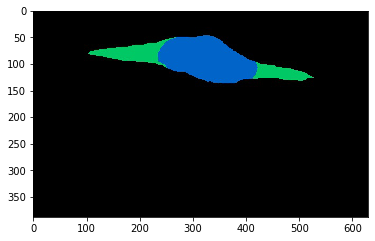

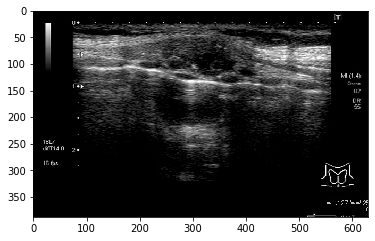

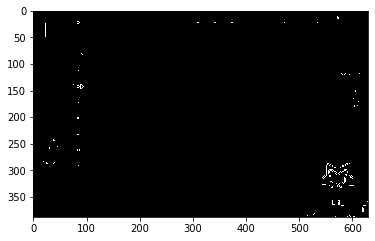

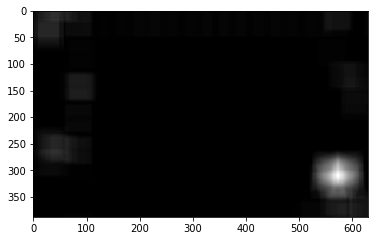

ct: [309 574]
[276:335,538:608]
sc:


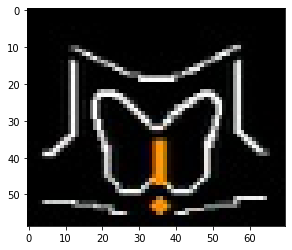

sc0


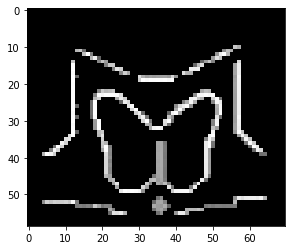

sc


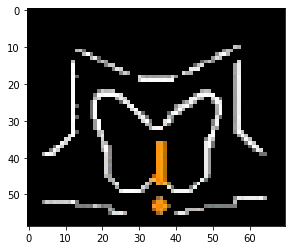

sh:


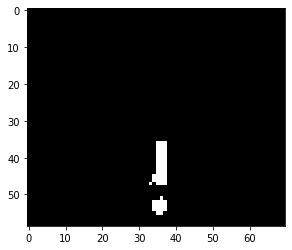

vertical
sc0


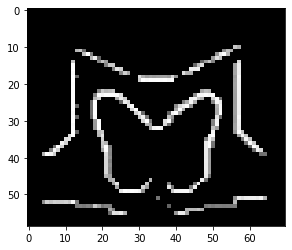

(59, 70)
cd: 36
sc_copy


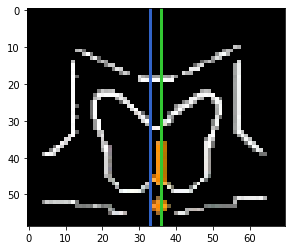

sc1:


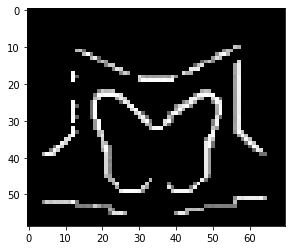

sc2


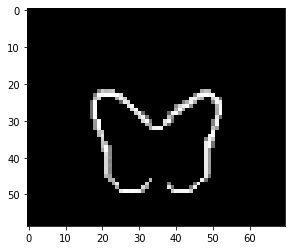

1 contours.


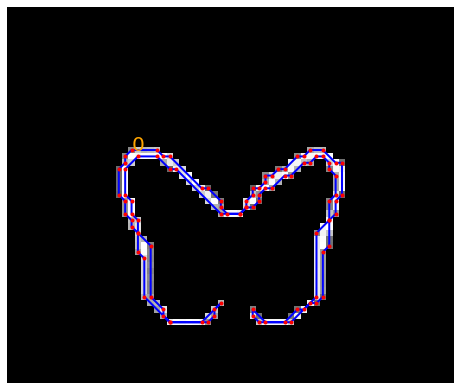

sc3


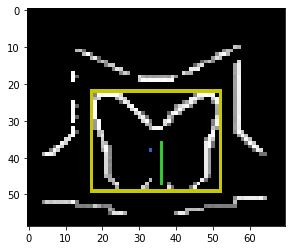


【 Thyroid 】
Thyroid is exist
numbers of pixel: 13176


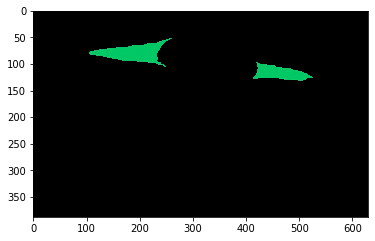

min_col 105
max_col 525

【 Nodule 】
Nodule is None
numbers of pixel: 0

【 Malignant 】
Malignant is exist
11325.5
No: 1


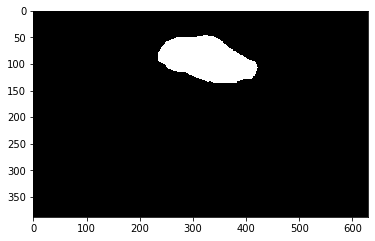

[1, 0, 1]
mal[1]:0.3095,0.7548

--------------------------

image_name: annotatedImage006
image:


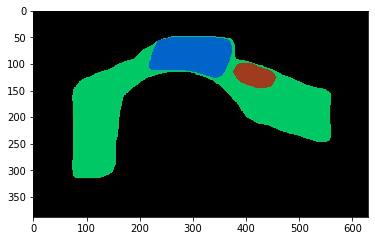

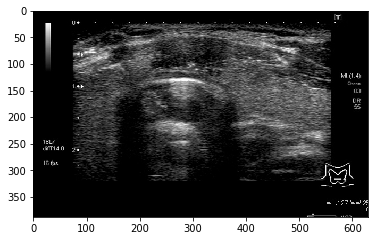

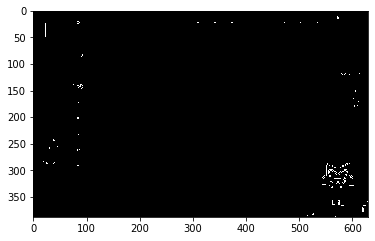

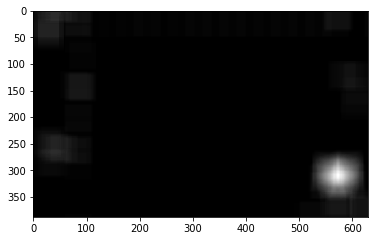

ct: [309 574]
[276:341,538:609]
sc:


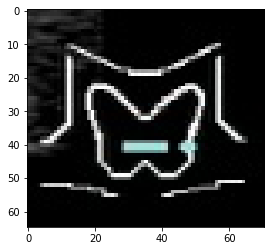

sc0


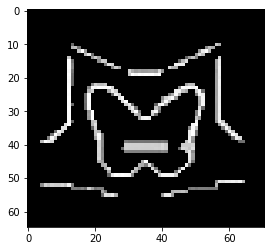

sc


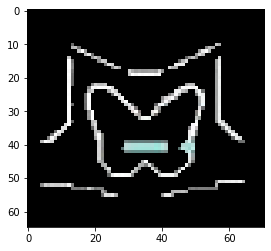

sh:


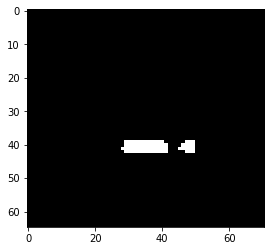

horizonal
sc0


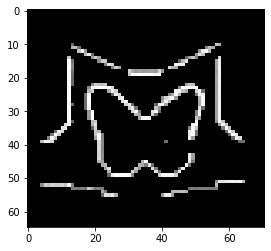

(65, 71)
sc_copy


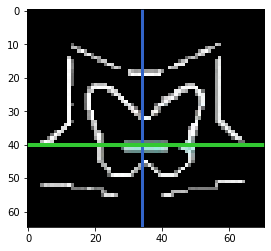

sc1:


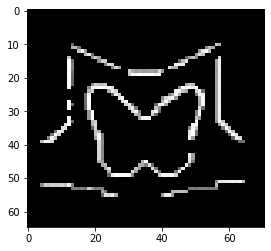

sc2


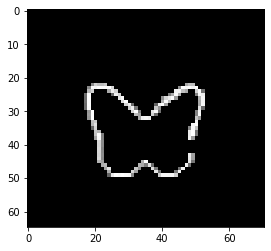

1 contours.


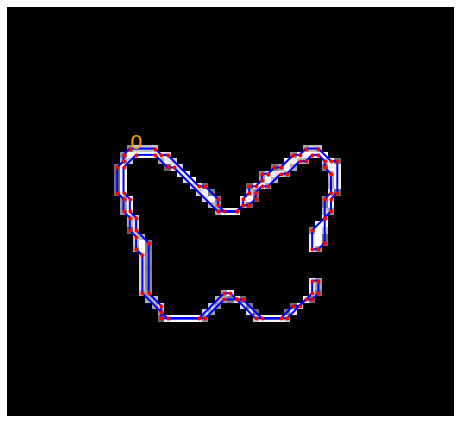

sc3


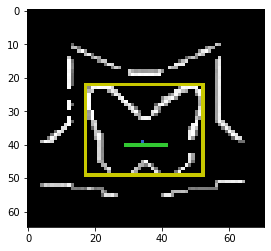


【 Thyroid 】
Thyroid is exist
numbers of pixel: 81887


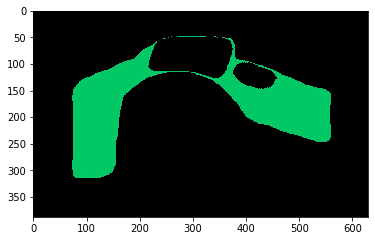

min_col 74
max_col 560

【 Nodule 】
Nodule is exist
2548.0
No: 1


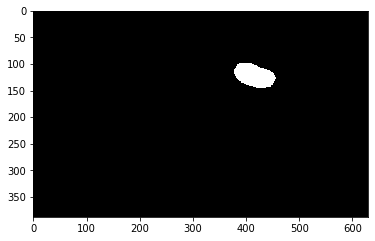


【 Malignant 】
Malignant is exist
9275.0
No: 1


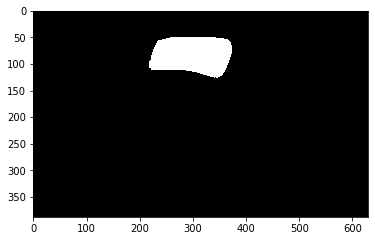

[1, 1, 1]
nod[1]:0.6255,0.786

--------------------------

mal[1]:0.2963,0.6173

--------------------------

image_name: annotatedImage013
image:


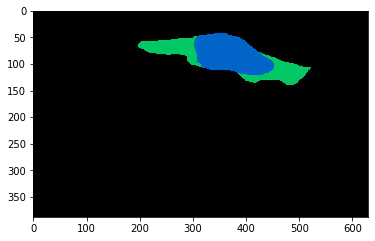

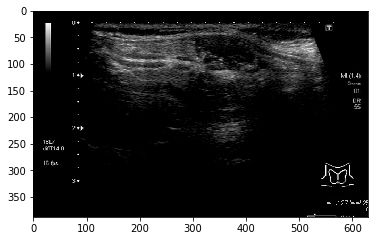

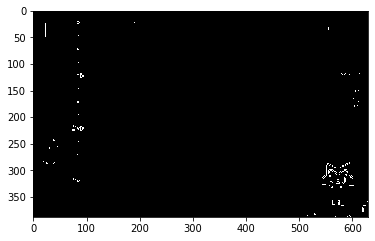

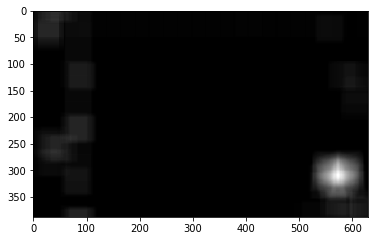

ct: [309 573]
[276:334,538:608]
sc:


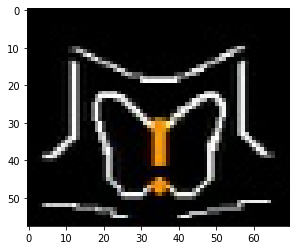

sc0


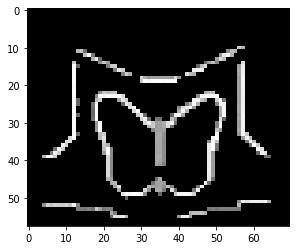

sc


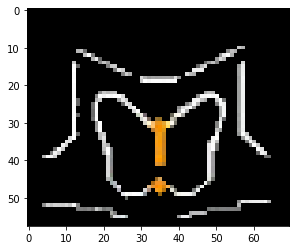

sh:


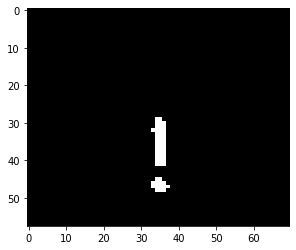

vertical
sc0


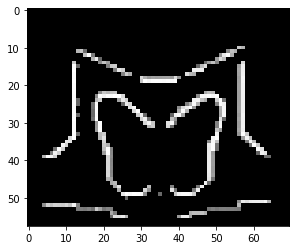

(58, 70)
cd: 34
sc_copy


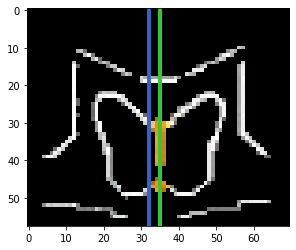

sc1:


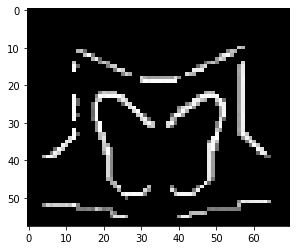

sc2


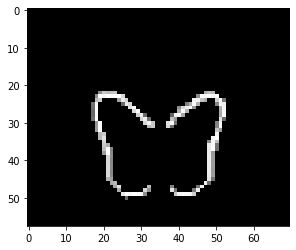

2 contours.


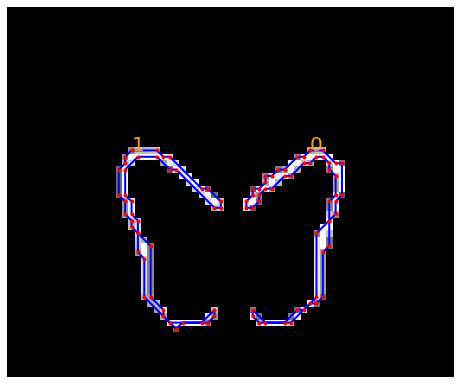

sc3


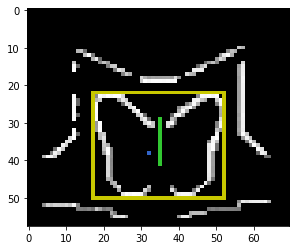


【 Thyroid 】
Thyroid is exist
numbers of pixel: 14705


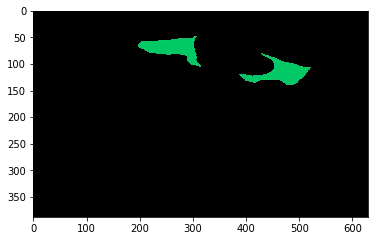

min_col 197
max_col 521

【 Nodule 】
Nodule is None
numbers of pixel: 0

【 Malignant 】
Malignant is exist
8064.0
No: 1


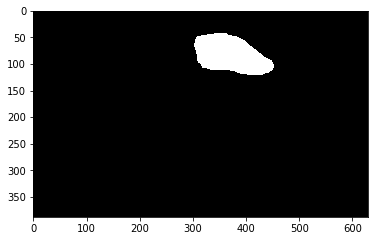

[1, 0, 1]
mal[1]:0.3272,0.7901

--------------------------

image_name: annotatedImage015
image:


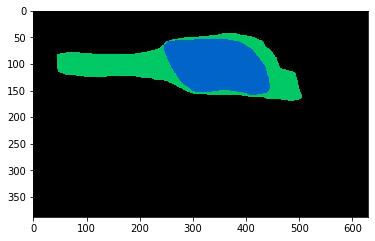

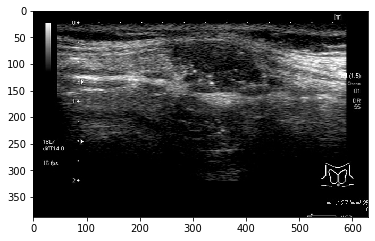

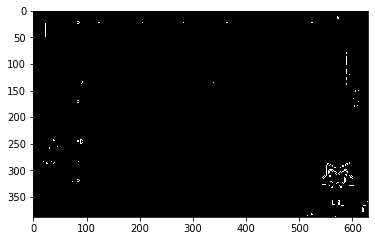

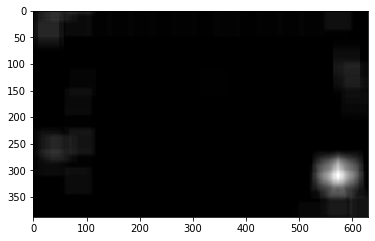

ct: [309 573]
[276:334,538:608]
sc:


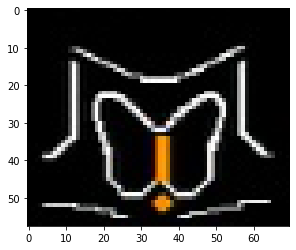

sc0


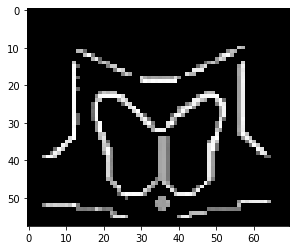

sc


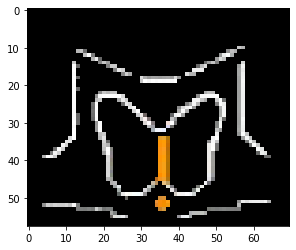

sh:


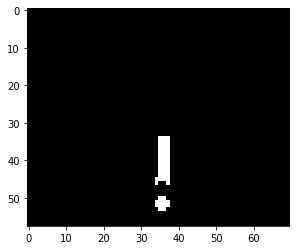

vertical
sc0


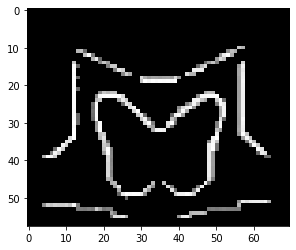

(58, 70)
cd: 35
sc_copy


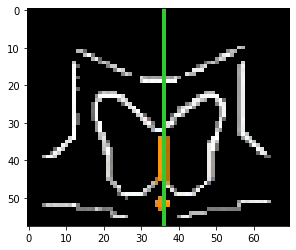

sc1:


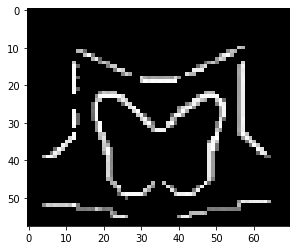

sc2


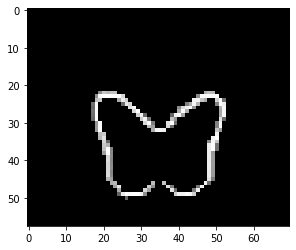

1 contours.


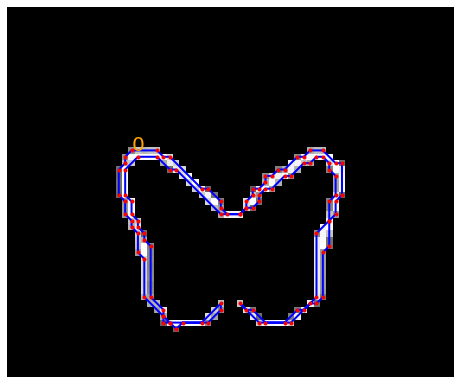

sc3


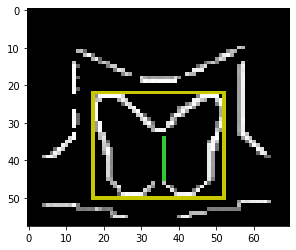


【 Thyroid 】
Thyroid is exist
numbers of pixel: 39345


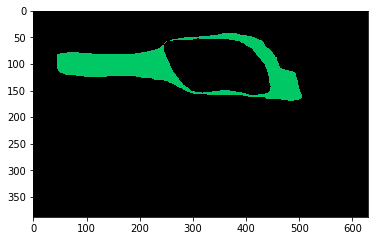

min_col 45
max_col 505

【 Nodule 】
Nodule is None
numbers of pixel: 0

【 Malignant 】
Malignant is exist
15873.0
No: 1


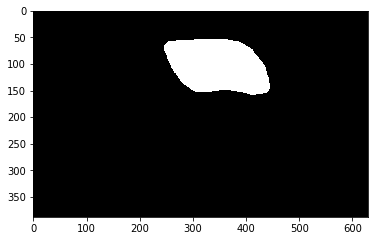

[1, 0, 1]
mal[1]:0.437,0.8696

--------------------------




In [47]:
df_probe = pd.DataFrame(columns=['image_name','direction','shape','(x,y)','(w,h)','cmax','cen_min','cen_max','cd','th_min','th_max','sc2'])
df_nodule = pd.DataFrame(columns = ['image_name','part_number','min_col','max_col','part'])
df_malignant = pd.DataFrame(columns = ['image_name','part_number','min_col','max_col','part'])

for img in tqdm(annotated_image_list):
    image_name = image_to_name(img,annotated_image_dic,False)
    image_name = image_to_name(img,annotated_image_dic,True)
    print('image:')
    imgplot(img)
    img0 = annotated_to_image(img,annotated_image_dic,image_dic)#元画像
    
    dst,ct = thyroid_detect(img0) #エコー画像上でスキーマがある位置を探索
    sc, trim_range = thyroid_trim(img0,dst,ct) #エコー画像からスキーマの切り抜き
    sh, direction = probe_detect(sc) #プローブの方向判定
    
    #甲状腺の中心、プローブの座標取得
    cmax,cd = thyroid_measure(sc,sh,direction) 
    th_min,th_max = probe_measure(sh,cd,direction)
    
    sc1 = clean_schema(sc,sh,direction) #ノイズの除去
    
    #スキーマから首を取り除く
    cen_row_min,cen_row_max,sc2 = remove_neck(sc1,cmax)
    
    #外接矩形の取得
    x,y,w,h = make_boundingRect(sc2)
    
    df_probe_temp = pd.Series([image_name,direction,sc2.shape,(x,y),(w,h), cmax, cen_row_min, cen_row_max, cd, th_min, th_max, sc2],index = df_probe.columns)
    df_probe = df_probe.append(df_probe_temp, ignore_index = True)
    
    #外接矩形、甲状腺の中心、プローブの表示
    sc3 = cv2.rectangle(cv2.cvtColor(sc1,cv2.COLOR_GRAY2BGR), (x, y), (x + w-1, y + h-1), [0,200,200])
    sc3[int((cen_row_min+cen_row_max)/2),cmax] = [200,100,50]
    if direction == 'vertical':
        sc3[th_min:th_max+1,cd] = [50,200,50]
    elif direction == 'horizonal':
        sc3[cd,th_min:th_max+1] = [50,200,50]
    print('sc3')
    imgplot(sc3)
    
    #from annotated_extract.ipynb
    i = img.copy()
    
    #bgrを基に器官の抽出を行う際にプローブが邪魔なので消す
    #t,b,l,r = trim_range
    #i[ct[0]-t:ct[0]+b,ct[1]-l:ct[1]+r]=0
    #print('image')
    #imgplot(i)
    
    
    df_nodule_temp, df_malignant_temp = judge_type(img,image_name)
    
    if type(df_nodule_temp) != int:
        df_nodule = df_nodule.append(df_nodule_temp, ignore_index = True)
        
    if type(df_malignant_temp) != int:
        df_malignant = df_malignant.append(df_malignant_temp, ignore_index = True)

In [48]:
df_probe

,image_name,direction,shape,"(x,y)","(w,h)",cmax,cen_min,cen_max,cd,th_min,th_max,sc2
0,annotatedImage002,vertical,"(59, 70)","(17, 22)","(36, 28)",33,30,46,36,36,47,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,annotatedImage006,horizonal,"(65, 71)","(17, 22)","(36, 28)",34,32,46,40,29,41,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,annotatedImage013,vertical,"(58, 70)","(17, 22)","(36, 29)",32,29,48,35,29,41,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,annotatedImage015,vertical,"(58, 70)","(17, 22)","(36, 29)",36,32,46,36,34,45,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [49]:
#スキーマを画像の中心に移動
def resize_schema(img0,x,y,w,h,m,n):
    if len(img0.shape) == 3:
        img = img0.copy()[y:y+h,x:x+w,]
        result = np.zeros((m, n, 3), np.uint8)
    else:
        img = img0.copy()[y:y+h,x:x+w]
        result = np.zeros((m, n), np.uint8)
    
    r = img.shape[0]
    c = img.shape[1]
    rb = result.shape[0]
    cb = result.shape[1]

    hrb=round(rb/2)
    hcb=round(cb/2)
    hr=round(r/2)
    hc=round(c/2)

    up = hrb-hr
    bottom = hrb+hr
    left = hcb-hc
    right = hcb+hc
    
    
    if r % 2 == 1 and c % 2 == 0:
        up = hrb-hr+1
        
    elif r % 2 == 0 and c % 2 == 1:
        left = hcb-hc+1
            
    elif r % 2 == 1 and c % 2 == 1:
        up = hrb-hr+1
        left = hcb-hc+1
        
    if len(img0.shape) == 3:
        result[up:bottom,left:right,] = img
    else:
        result[up:bottom,left:right] = img
    
    return result, up, bottom, left, right


annotatedImage013
処理:外接矩形の縦方向補正


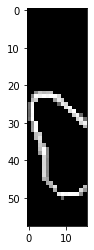

1 contours.


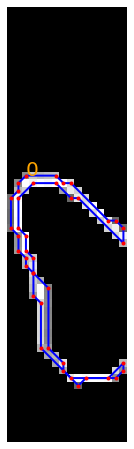

補正後(w,h): (36, 29)
annotatedImage015
処理:外接矩形の縦方向補正


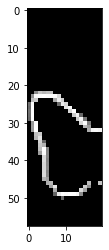

2 contours.


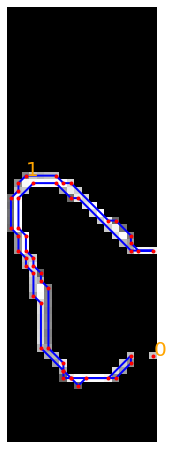

補正後(w,h): (36, 29)
処理(全体):cmaxを外接矩形から補正


In [50]:
#step1: 外接矩形のshapeを決定
#step1.1:shapeの最頻値(mode)を取る
if df_probe['(w,h)'].nunique()>1:
    if df_probe['(w,h)'].value_counts()[0]/len(df_probe)>=0.5:
        (w,h) = df_probe['(w,h)'].value_counts().index[0]
    else:
        print('error: 外接矩形の形が一致しません。それぞれの画像における矩形を確認してください。')
else:
    (w,h) = df_probe['(w,h)'].unique()[0]

#step1.2: shapeが違うものは、使っていない方のプローブを利用して縦方向を補正する

for i in range(len(df_probe)):
    x, y = df_probe['(x,y)'][i]
    w_temp, h_temp = df_probe['(w,h)'][i]
    cmax = df_probe['cmax'][i]
    cd = df_probe['cd'][i]
    th_min = df_probe['th_min'][i]
    th_max = df_probe['th_max'][i]
    direction = df_probe['direction'][i]
    img = df_probe['sc2'][i]
    
    if abs(w_temp - w)>2 or abs(h_temp - h)>2:
        print('error: {}の外接矩形の形がずれています。'.format(df_probe['image_name'][i]))
    
    elif abs(w_temp - w)== 0 and abs(h_temp - h) <= 2 and abs(h_temp - h) > 0:
        print(df_probe['image_name'][i])
        print("処理:外接矩形の縦方向補正")
        if direction == 'vertical':
            if cd < cmax:
                img = img[:,cmax:x+w+1]
                imgplot(img)
            
            else:
                img = img[:,x:cmax+1]
                imgplot(img)
        else:
            if cmax < (th_min+th_max)/2:
                img = img[:,x:cmax+1]
                imgplot(img)
            else:
                img = img[:,cmax:x+w+1]
                imgplot(img)
                
        x1,y1,w1,h1 = make_boundingRect(img)
        df_probe['(x,y)'][i] = (x,y1)
        df_probe['(w,h)'][i] = (w_temp,h1)
        print("補正後(w,h):",(w_temp,h1))
    
    
#step1.3: 正しいものについてcmaxと各頂点の距離を計算する
distance_list = []
for i in range(len(df_probe)):
    if (w,h) == df_probe['(w,h)'][i]:
        (x,y) = df_probe['(x,y)'][i]
        dis_l = df_probe['cmax'][i] - x
        dis_r = x + w - 1 - df_probe['cmax'][i]
        dis_u = df_probe['cen_min'][i] - y
        dis_b = y + h - 1 - df_probe['cen_max'][i]
        
        distance_list.append((dis_l,dis_r,dis_u,dis_b))
        
count = Counter(distance_list)
if len(df_probe)>2:
    if count.most_common(1)[0][1]/len(df_probe) > 0.5:
        dist_cmax =  count.most_common(1)[0][0]
    else:
        cmax_list = [df_probe['(x,y)'][i][0] + int(Decimal(str(w/2)).quantize(Decimal('0'), rounding=ROUND_HALF_UP))for i in range(len(df_probe))]
        count_cmax = Counter(cmax_list)
        if count_cmax.most_common(1)[0][1]/len(df_probe) > 0.5:
            cmax =  count_cmax.most_common(1)[0][0]
            df_probe['cmax'] = cmax
            print('処理(全体):cmaxを外接矩形から補正')
else:
    cmax_temp = df_probe['(x,y)'][i][0] + int(Decimal(str(w/2)).quantize(Decimal('0'), rounding=ROUND_HALF_UP))
    if cmax_temp != df_probe['cmax'][0]:
        df_probe['cmax'] = cmax_temp
        print('処理(全体):cmaxを外接矩形から補正')     

        
#Step2: 画像のサイズを揃える
shape_list = list(df_probe['shape'])
m_list = []
n_list = []

for i in shape_list:
    a,b = i
    m_list.append(a)
    n_list.append(b)
    
m = int(statistics.median(m_list))
n = int(statistics.median(n_list))

if w % 2 == 0 and n % 2 == 1:
    n = n + 1
elif w % 2 == 1 and n % 2 == 0:
    n = n + 1

if h % 2 == 0 and m % 2 == 1:
    m = m + 1
elif h % 2 == 1 and m % 2 == 0:
    m = m + 1

df_probe_fixed = pd.DataFrame(columns = df_probe.columns)

#Step3: 外接矩形が画像の中心になるように移動する
#Step4: df_probeの座標を更新する
for i in range(len(df_probe)):
    (x,y) = df_probe['(x,y)'][i]
    sc2 = df_probe['sc2'][i] #scでよいか要確認
    direction = df_probe['direction'][i]
    result, up, bottom, left, right = resize_schema(sc2,x,y,w,h,m,n)
    
    a = left - x
    b = up - y
    
    cmax = df_probe['cmax'][i] + a
    cen_min = df_probe['cen_min'][i] + b
    cen_max = df_probe['cen_max'][i] + b
    if direction == 'vertical':
        cd = df_probe['cd'][i] + a
        th_min = df_probe['th_min'][i] + b
        th_max = df_probe['th_max'][i] + b
    else:
        cd = df_probe['cd'][i] + b
        th_min = df_probe['th_min'][i] + a
        th_max = df_probe['th_max'][i] + a
        
    image_name = df_probe['image_name'][i]
    shape = (m, n)
    (x, y) = (left, up)
    (w_temp, h_temp) = (right - left, bottom - up)
    
    df_temp = pd.Series([image_name,direction,shape,(x,y),(w_temp,h_temp), cmax, cen_min, cen_max, cd, th_min, th_max, result],index = df_probe.columns)
    df_probe_fixed = df_probe_fixed.append(df_temp, ignore_index = True)

    
#step5:cmax, cen_min, cen_maxについて統一
#これ以降cen_min,cen_maxは使用しない
if df_probe_fixed['cmax'].nunique()>1:
    if df_probe_fixed['cmax'].value_counts().iat[0]/len(df_probe_fixed)>0.5:
        cmax = df_probe_fixed['cmax'].value_counts().index[0]

if df_probe_fixed['cen_min'].nunique()>1:
    if df_probe_fixed['cen_min'].value_counts().iat[0]/len(df_probe_fixed)>0.5:
        cen_min = df_probe_fixed['cen_min'].value_counts().index[0]
        
if df_probe_fixed['cen_max'].nunique()>1:
    if df_probe_fixed['cen_max'].value_counts().iat[0]/len(df_probe_fixed)>0.5:
        cen_max = df_probe_fixed['cen_max'].value_counts().index[0]


for i in range(len(df_probe_fixed)):
    if df_probe_fixed['(w,h)'][i] == (w,h):
        df_probe_fixed['cmax'][i] = cmax
        df_probe_fixed['cen_min'][i] = cen_min
        df_probe_fixed['cen_max'][i] = cen_max        

df_probe_fixed = df_probe_fixed.rename(columns={'sc2':'thy'})

In [52]:
df_probe_fixed

,image_name,direction,shape,"(x,y)","(w,h)",cmax,cen_min,cen_max,cd,th_min,th_max,thy
0,annotatedImage002,vertical,"(58, 70)","(17, 15)","(36, 28)",35,25,39,36,29,40,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,annotatedImage006,horizonal,"(58, 70)","(17, 15)","(36, 28)",35,25,39,33,29,41,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,annotatedImage013,vertical,"(58, 70)","(17, 15)","(36, 28)",35,25,39,35,22,34,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,annotatedImage015,vertical,"(58, 70)","(17, 15)","(36, 28)",35,25,39,36,27,38,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


### アノテーション画像から甲状腺の中心、端を特定してプローブの位置を補正する

In [53]:
#甲状腺(thy)と結節(Nod)を抽出し，結合する
def make_img_Thy_Nod_Mal(img, Thy_Lower, Thy_Upper, Nod_Lower, Nod_Upper, Mal_Lower, Mal_Upper, threshold = 20):
    Thy = detect_color(img,Thy_Lower,Thy_Upper)
    Nod = detect_color(img,Nod_Lower,Nod_Upper)
    Mal = detect_color(img,Mal_Lower,Mal_Upper)

    Thy_gray = clean_image(np.uint8(cv2.cvtColor(Thy,cv2.COLOR_BGR2GRAY)))
    Nod_gray = clean_image(np.uint8(cv2.cvtColor(Nod,cv2.COLOR_BGR2GRAY)))
    Mal_gray = clean_image(np.uint8(cv2.cvtColor(Mal,cv2.COLOR_BGR2GRAY)))

    
    bitwise_temp = cv2.bitwise_or(Thy_gray, Nod_gray)
    bitwise_or = cv2.bitwise_or(bitwise_temp, Mal_gray)
    
    # 二値化(閾値を超えた画素を255にする。)
    ret, img_thy_nod_mal = cv2.threshold(bitwise_or, threshold, 255, cv2.THRESH_BINARY)
    imgplot(img_thy_nod_mal)
    
    return img_thy_nod_mal

In [54]:
#外接矩形からの中心とプローブの位置関係から甲状腺の中心の方向を判定
def judge_thy_LR(df_horizonal,image_name):
    df_temp = df_horizonal[df_horizonal['image_name'] == image_name].reset_index(drop=True)
    cmax = df_temp['cmax'][0]
    th_min = df_temp['th_min'][0]
    th_max = df_temp['th_max'][0]
    
    if (th_min + th_max)/ 2 >= cmax:
        thy_LR = 'left'
    else:
        thy_LR = 'right'
        
    print('thy_LR:',thy_LR)
    return thy_LR

In [55]:
#甲状腺全体における各列の幅を計算
def clac_width_thy(img_thy_nod):
    m,n = img_thy_nod.shape
    min_list = []
    width_list = []
    for i in range(n):
        img_col = img_thy_nod[:,i]
        if (img_col != 0).any():
            nzero_list = np.where(img_col != 0)[0].tolist()
            min_temp = min(nzero_list)
            max_temp = max(nzero_list)
        
            width = max_temp - min_temp
        else:
            width = 0
            min_temp = 0
        
        width_list.append(width)
        min_list.append(min_temp)
        
    return min_list, width_list


In [56]:
#甲状腺の中心があるか判定
def judge_center_edge(min_width,max_width,img_thy_nod):
    if min_width > max_width * 0.3:
        center_exist = False
    else:
        center_exist = True
    
    return center_exist


#甲状腺の中心座標の特定
#幅が最大の幅の30%以下の列のなかで一番皮膚に近いところを中心として判定
def detect_center_thy(width_list_judge, max_width, cen_rate = 0.3):
    width_list_judge = np.array(width_list_judge)
    cen_col_list = np.where((width_list_judge <= max_width * cen_rate) & (width_list_judge != 0))[0].tolist()
    for i in cen_col_list:
        row_temp = np.inf
        for i in cen_col_list:
            if row_temp > min_list[i]:
                row_temp = min_list[i]
                min_col = i
    if thy_LR == 'right':
        min_col = img0.shape[1] - 1 - min_col
    
    return min_col

In [57]:
#スキーマのエッジの座標を計算
def calc_schema_edge(img,thy_list,thy_LR):
    thy_temp = [i for i in thy_list if (i != img).any()]

    plot_list = []
    edge_list = []
    m,n = img.shape

    #端点の座標計算
    for thy in thy_temp:
        x= thy[cd,:]
        num = 0
        if thy_LR == 'left':
            for i in range(n):
                if x[n-1-i] > 0 and num == 0:
                    num += 1
                    plot_list.append(n-1-i)
                elif x[n-1-i] > 0 and num == 1:
                    plot_list.append(n-1-i)
            
                elif x[n-1-i] == 0 and num == 1:
                    break
        else:
            for i,y in enumerate(x):
                if y > 0 and num == 0:
                    num += 1
                    plot_list.append(i)
                elif y > 0 and num == 1:
                    plot_list.append(i)
            
                elif y == 0 and num == 1:
                    break 
        edge = int(statistics.median(plot_list))
        edge_list.append(edge)

    if len(set(edge_list))>1:
        if Counter(edge_list).most_common(1)[0][0]/len(edge_list)>=0.5:
            edge = Counter(edge_list).most_common(1)[0][0]
        else:
            print('error: 各画像におけるプローブの位置が一致しません。それぞれの画像を確認してください。')
    else:
        edge = edge_list[0]
    #print('edge')
    #print(edge)
    print('edge_list:',edge_list)
    return edge

In [58]:
def judge_edge(img0, img_thy_nod, thy_LR, edge_range=20):
    
    i0 = grayscale(annotated_to_image(img0,annotated_image_dic,image_dic)) # convert to gray scale
    top,bottom,left,right = cut(annotated_to_image(img0,annotated_image_dic,image_dic))
    i0_copy = i0.copy()
    l_edge,r_edge = measure_col_thy(img_thy_nod)
    
    print('left:{},right:{}'.format(left,right))
    print('l_edge:{},r_edge:{}'.format(l_edge,r_edge))
    print('\n')
    print('original_image')
    imgplot(i0_copy)
    
    s_cen = np.zeros(i0.shape[1])
    width_list= []
    for i in range(img_thy_nod.shape[1]):
        img_temp = img_thy_nod[:,i]
        if (img_temp != 0).any():
            nzero_list = np.where(img_temp != 0)[0].tolist()
            min_temp = min(nzero_list)
            max_temp = max(nzero_list)
            width = max_temp - min_temp
            width_list.append(int(width))
            s_cen[i] = (min_temp + max_temp) / 2
        else:
            width_list.append(0)
    
    if (thy_LR == 'right' and left + edge_range <= l_edge) or (thy_LR =='left' and right - edge_range >= r_edge):
        edge_exist = True
    
    elif (thy_LR == 'right' and s_cen[l_edge + 4] - 20 >= s_cen[l_edge + edge_range]) or (thy_LR == 'left' and s_cen[r_edge - 4] - 20 >= s_cen[r_edge - edge_range]):
        edge_exist = False
        print(s_cen[l_edge + 4])
        print(s_cen[l_edge + edge_range])
        
    elif (thy_LR == 'right' and np.mean(np.array(width_list[l_edge:l_edge+5])) <= 20) or(thy_LR == 'left' and np.mean(np.array(width_list[r_edge-4:r_edge+1])) <= 20):
        edge_exist  = True
        
    else:
        edge_exist = False
        
        
    return edge_exist

annotatedImage006
img0


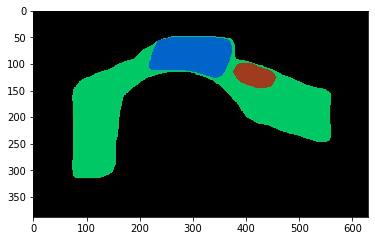

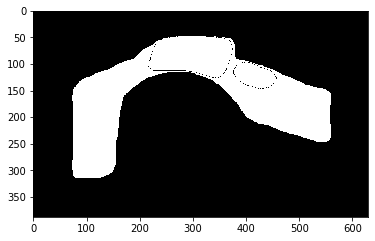

thy_LR: left
min_width: 139
max_width: 198
left:74,right:563
l_edge:74,r_edge:560


original_image


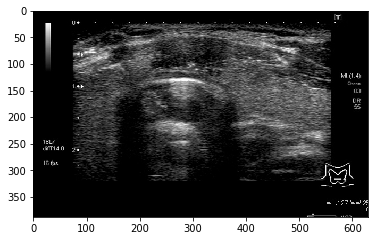

center: False
edge: False



In [59]:
df_horizonal = df_probe_fixed[df_probe_fixed['direction'] == 'horizonal'].reset_index(drop=True)
if len(df_horizonal) > 0:
    for i,image_name in enumerate(tqdm(df_horizonal['image_name'].to_numpy().tolist())):
        print(image_name)
        img0 = annotated_image_dic[image_name]
        
        # 色で各部位を抽出するときにプローブの色が干渉するので、スキーマを削除
        #img = image_mask_schema(img0)
        print('img0')
        imgplot(img0)
        #結節と甲状腺と悪性腫瘍のみを抽出した画像作成
        img_thy_nod = make_img_Thy_Nod_Mal(img0, Thy_Lower, Thy_Upper, Nod_Lower, Nod_Upper, Mal_Lower, Mal_Upper, threshold = 50)
        
        #甲状腺の中心がエコー画像のどちら側にあるか判定
        thy_LR = judge_thy_LR(df_horizonal, image_name) 
        
        #甲状腺の各列の幅と皮膚との距離を計算
        min_list, width_list = clac_width_thy(img_thy_nod)
        max_width = max(width_list) 
        
        #探索する列を決定
        if thy_LR == 'left':
            col_max = np.where(np.array(width_list) == max_width)[0][0]
            width_list_judge = width_list[:col_max+1]
            min_list_judge = min_list[:col_max+1]
        elif thy_LR == 'right':
            col_max = np.where(np.array(width_list) == max_width)[0][-1]
            width_list_judge = width_list[-1:col_max-1:-1]
            min_list_judge = min_list[-1:col_max-1:-1]

        min_width = min([i for i in width_list_judge if i>0])

        print('min_width:',min_width)
        print('max_width:',max_width)
        
        '''
        ===================================================
        #甲状腺の中心があるか判定(ここでedgeの判定もしたい)
        '''
        center_exist = judge_center_edge(min_width,max_width,img_thy_nod)
        edge_exist = judge_edge(img0, img_thy_nod, thy_LR)
        '''
        #甲状腺の端が存在しているか要検討
        ===================================================
        '''
        print('center:',center_exist)
        print('edge:',edge_exist)
        
        if center_exist == True and edge_exist == True:
        #中心の座標(列)
            min_col = detect_center_thy(width_list_judge, max_width, cen_rate = 0.3)
        #両端の座標(列)
            l_edge,r_edge = measure_col_thy(img_thy_nod)
            print('center_col:',min_col)
            print('l_edge,r_edge:',l_edge,r_edge)
            
            #プローブの座標
            cd = df_horizonal['cd'][i]
            th_min = df_horizonal['th_min'][i]
            th_max = df_horizonal['th_max'][i]
            
            #スキーマ上の甲状腺の座標
            cmax = df_probe_fixed['cmax'][i]
            
            
            #スキーマ
            img_thy = df_horizonal['thy'][i]
            thy_list =  list(df_probe_fixed['thy'])
            edge = calc_schema_edge(img_thy, thy_list,thy_LR)
            
            
    

        
            if thy_LR == 'right' and center_exist == True:
                th_min = edge
                th_max = int(edge + (cmax - edge) * (r_edge-l_edge)/(min_col - l_edge))

            elif thy_LR == 'left' and center_exist == True:
                th_min = int(edge - (edge - cmax) * (r_edge-l_edge)/(r_edge - min_col))
                th_max = edge
                
            print('cd:',cd)
            print('edge:',edge)
            print('th_min:',th_min)
            print('th_max:',th_max)
    
            df_probe_fixed['th_min'].mask(df_probe_fixed['image_name'] == image_name, th_min ,inplace = True)
            df_probe_fixed['th_max'].mask(df_probe_fixed['image_name'] == image_name, th_max ,inplace = True)

In [62]:
df_probe_fixed

,image_name,direction,shape,"(x,y)","(w,h)",cmax,cen_min,cen_max,cd,th_min,th_max,thy
0,annotatedImage002,vertical,"(58, 70)","(17, 15)","(36, 28)",35,25,39,36,29,40,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,annotatedImage006,horizonal,"(58, 70)","(17, 15)","(36, 28)",35,25,39,33,29,41,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,annotatedImage013,vertical,"(58, 70)","(17, 15)","(36, 28)",35,25,39,35,22,34,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,annotatedImage015,vertical,"(58, 70)","(17, 15)","(36, 28)",35,25,39,36,27,38,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [63]:
#腫瘍の位置をschemaの座標に変換
def recalc_nod(df):
    nod_min_list = []
    nod_max_list = []

    for i in range(len(df)):
        cd = df['cd'][i]
        th_min = df['th_min'][i]
        th_max = df['th_max'][i]
        min_col = df['min_col'][i]
        max_col = df['max_col'][i]
    
        if df['direction'][i] == 'vertical':
            nod_min = [int(Decimal(str(th_min+(th_max-th_min)*min_col)).quantize(Decimal('0'), rounding=ROUND_HALF_UP)), cd]
            nod_max = [int(Decimal(str(th_min+(th_max-th_min)*max_col)).quantize(Decimal('0'), rounding=ROUND_HALF_UP)), cd]
        else:
            nod_min = [cd, int(Decimal(str(th_min+(th_max-th_min)*min_col)).quantize(Decimal('0'), rounding=ROUND_HALF_UP))]
            nod_max = [cd, int(Decimal(str(th_min+(th_max-th_min)*max_col)).quantize(Decimal('0'), rounding=ROUND_HALF_UP))]
    
        nod_min_list.append(nod_min)
        nod_max_list.append(nod_max)

    df['nod_min'] = pd.Series(nod_min_list)
    df['nod_max'] = pd.Series(nod_max_list)
    
    return df

In [64]:
df_probe_merge = df_probe_fixed[['image_name','direction','cd','th_min','th_max']]
df_nodule_merge = df_nodule.drop(columns = ['part'])
df_nodule_probe = pd.merge(df_nodule_merge, df_probe_merge, on='image_name')
df_malignant_merge = df_malignant.drop(columns = ['part'])
df_malignant_probe = pd.merge(df_malignant_merge, df_probe_merge, on='image_name')

In [65]:
df_nodule_probe = recalc_nod(df_nodule_probe)
df_malignant_probe = recalc_nod(df_malignant_probe)

In [66]:
df_nodule_probe

,image_name,part_number,min_col,max_col,direction,cd,th_min,th_max,nod_min,nod_max
0,annotatedImage006,1,0.625514,0.786008,horizonal,33,29,41,"[33, 37]","[33, 38]"


## 仮表示用の整形済スキーマの読み込み及び表示

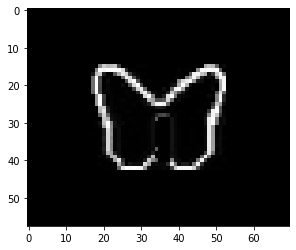

In [68]:
#Patient1:(x,y)=(17,23)
#Patient2:(x,y)=(20,19)
#Patient3:(x,y)=(20,22)
#Patient4:(x,y)=(17,22)
#Patient5:(x,y)=(20,22)

img_schema = cv2.imread(str(data_path/'schema.png'))
#img_schema = np.uint8(cv2.cvtColor(img_schema,cv2.COLOR_BGR2GRAY))
x, y = (17,22)
w, h = df_probe_fixed['(w,h)'][0]
m, n = df_probe_fixed['shape'][0]

img_schema, top, bottom, left, right = resize_schema(img_schema,x,y,w,h,m,n)
imgplot(img_schema)

### img_schemaにプロットしてみる

annotatedImage006


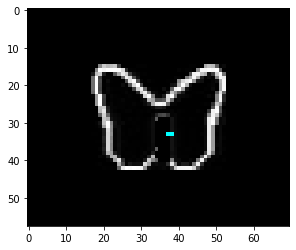

annotatedImage002



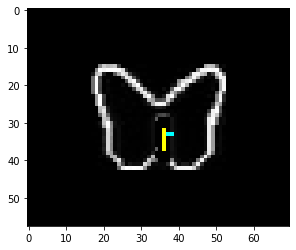

annotatedImage006



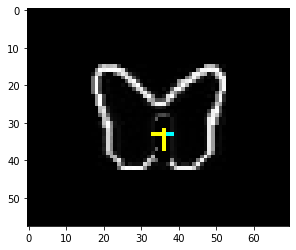

annotatedImage013



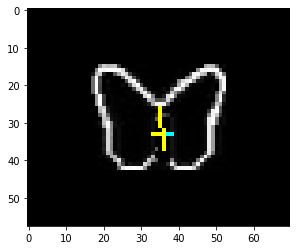

annotatedImage015



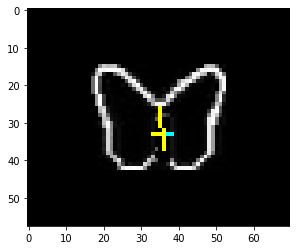

In [69]:
img_schema_copy = img_schema.copy()
for i in range(len(df_nodule_probe)):
    #img_schema_part = img_schema.copy()
    nod_min = (df_nodule_probe['nod_min'][i][1], df_nodule_probe['nod_min'][i][0])
    nod_max = (df_nodule_probe['nod_max'][i][1], df_nodule_probe['nod_max'][i][0])
    cv2.line(img_schema_copy, nod_min, nod_max, (255,255,0))
    #cv2.line(img_schema_part, nod_min, nod_max, (255,255,0))
    print(df_nodule_probe['image_name'][i])
    #imgplot(img_schema_part)
    imgplot(img_schema_copy)
    print('================')

for i in range(len(df_malignant_probe)):
    #img_schema_copy = img_schema.copy()
    print(df_malignant_probe['image_name'][i])
    mal_min = (df_malignant_probe['nod_min'][i][1], df_malignant_probe['nod_min'][i][0])
    mal_max = (df_malignant_probe['nod_max'][i][1], df_malignant_probe['nod_max'][i][0])
    print()
    cv2.line(img_schema_copy, mal_min, mal_max, (0,255,255))
    imgplot(img_schema_copy)
    print('================')



### 複数のエコー画像から結節のクラスター作成を行う

In [141]:
def judge_intersect(p1, p2, d1, p3, p4, d2):
    if d1 != d2:
        if d1 == 'vertical':
            h_range = list(range(p1[0], p2[0]+1))
            h = p3[0]
            w_range = list(range(p3[1], p4[1]+1))
            w = p1[1]
        else:
            h_range = range(p3[0], p4[0]+1)
            h = p1[0]
            w_range = list(range(p1[1], p2[1]+1))
            w = p3[1]
            
        return h in h_range and w in w_range
        
    elif d1 == 'vertical' and d2 == 'vertical':
        h1 = list(range(p1[0], p2[0]+1))
        h2 = list(range(p3[0], p4[0]+1))
        if p1[1] == p3[1] and len(set(h1)&set(h2)) > 0:
            return True
        else:
            return False

    else:
        h1 = list(range(p1[1], p2[1]+1))
        h2 = list(range(p3[1], p4[1]+1))
        if len(set(h1)&set(h2)) > 0 and p1[0] == p3[0]:
            return True
        else:
            return False
        
def calc_near(p1, p2, d1, p3, p4, d2):
    p1 = np.array(p1)
    p2 = np.array(p2)
    p3 = np.array(p3)
    p4 = np.array(p4)
    if d1 != d2:
        if d1 == 'horizonal':
            w_range = list(range(p1[1], p2[1]+1))
            h = p1[0]
        
            w = p3[1]
            h_range = list(range(p3[0],p4[0]+1))
        
        else:
            w_range = list(range(p3[1], p4[1]+1))
            h = p3[0]
        
            w = p1[1]
            h_range = list(range(p1[0],p2[0]+1))
        
        if w in w_range:
            return (min(abs(min(h_range)-h),abs(max(h_range)-h)), 0)
        elif h in h_range:
            return (0, min(abs(min(w_range)-w),abs(min(w_range)-w)))
        else:
            dis_list = [p3 - p1, p4 - p1, p3 - p2, p4 - p2]
            dis = (100,100)
            for i in dis_list:
                if sum(dis)>sum(i):
                    dis = i
            return tuple(dis)
        
    elif d1 == 'vertical':
        dis_w = abs(p1[1] - p3[1])
        if p1[0] <= p3[0]:
            if p2[0] >= p3[0]:
                return (0,dis_w)
            else:
                return (p3[0]-p2[0],dis_w)
            
        else:
            if p1[0] <= p4[0]:
                return (0,dis_w)
            else:
                return (p1[0]-p4[0],dis_w)
    else:
        dis_h = abs(p1[0] - p3[0])
        if p1[1] <= p3[1]:
            if p2[1] >= p3[1]:
                return (dis_h, 0)
            else:
                return(dis_h,p3[1] - p2[1])
        else:
            p1[1] >= p3[1]
            if p1[1] <= p4[1]:
                return (dis_h, 0)
            else:
                return(dis_h, p1[1] - p4[1])

In [142]:
def judge_intersect_near(df):
    intersect_list = []
    near_list = []
    for i in range(len(df)):
        for j in range(i+1,len(df)):
            p1 = df['nod_min'][i]
            p2 = df['nod_max'][i]
            d1 = df['direction'][i]
        
            p3 = df['nod_min'][j]
            p4 = df['nod_max'][j]
            d2 = df['direction'][j]
        
            if judge_intersect(p1, p2, d1, p3, p4, d2) == True and df['image_name'][i] != df['image_name'][j]:
                intersect_list.append([i,j])
                #img_schema_copy = img_schema.copy()
                #cv2.line(img_schema_copy, tuple(list(reversed(p1))), tuple(list(reversed(p2))), 255)
                #cv2.line(img_schema_copy, tuple(list(reversed(p3))), tuple(list(reversed(p4))), 255)
                #imgplot(img_schema_copy)
        
            else:
                h_dis, w_dis = calc_near(p1, p2, d1, p3, p4, d2)
                if df['image_name'][i] != df['image_name'][j] and h_dis <= 2 and w_dis <= 1:
                    near_list.append([i,j]) 
                    #img_schema_copy = img_schema.copy()
                    #cv2.line(img_schema_copy, tuple(list(reversed(p1))), tuple(list(reversed(p2))), 255)
                    #cv2.line(img_schema_copy, tuple(list(reversed(p3))), tuple(list(reversed(p4))), 255)
                    #imgplot(img_schema_copy)
        
                elif df['image_name'][i] != df['image_name'][j] and h_dis <= 1 and w_dis <= 2:
                    near_list.append([i,j])
                    #img_schema_copy = img_schema.copy()
                    #cv2.line(img_schema_copy, tuple(list(reversed(p1))), tuple(list(reversed(p2))), 255)
                    #cv2.line(img_schema_copy, tuple(list(reversed(p3))), tuple(list(reversed(p4))), 255)
                    #imgplot(img_schema_copy)
    return intersect_list,near_list 

In [143]:
#最初にintersect_listをもとに同じ結節のグループを作る
def make_cluster(df,intersect_list,near_list):
    cluster_dic = {}
    n_cluster = 0


    for i in range(len(df)):
        for j in intersect_list:
            a, b = j

            if a == i and a in cluster_dic:
                if b not in cluster_dic:
                    cluster_dic[b] = cluster_dic[a]
                elif cluster_dic[b] < cluster_dic[a]:
                    keys = [k for k, v in cluster_dic.items() if v == cluster_dic[a]]
                    for key in keys:
                        cluster_dic[key] = cluster_dic[b]
                
                elif cluster_dic[b] > cluster_dic[a]:
                    keys = [k for k, v in cluster_dic.items() if v == cluster_dic[b]]
                    for key in keys:
                        cluster_dic[key] = cluster_dic[a]
            
            elif a == i and a not in cluster_dic:
                if b in cluster_dic:
                    cluster_dic[a] = cluster_dic[b]
                else:
                    cluster_dic[a] = n_cluster + 1
                    cluster_dic[b] = cluster_dic[a]
                    
            elif b == i and b in cluster_dic:
                if a not in cluster_dic:
                    print('error')
                elif cluster_dic[b] < cluster_dic[a]:
                    keys = [k for k, v in cluster_dic.items() if v == cluster_dic[a]]
                    for key in keys:
                        cluster_dic[key] = cluster_dic[b]
                
                elif cluster_dic[b] > cluster_dic[a]:
                    keys = [k for k, v in cluster_dic.items() if v == cluster_dic[b]]
                    for key in keys:
                        cluster_dic[key] = cluster_dic[a]
            elif b == i and b not in cluster_dic:
                print('error')
                
                
            #クラスタ数の更新
            cluster_list = sorted(list(set(cluster_dic.values())))
            n_cluster = len(cluster_list)
            for index,cluster in enumerate(cluster_list):
                keys = [k for k, v in cluster_dic.items() if v == cluster]
                for key in keys:
                    cluster_dic[key] = index + 1

            
    #near_list
    for i in range(len(df_nodule_probe)):
        for j in near_list:
            a, b = j

            if a == i and a in cluster_dic:
                if b not in cluster_dic:
                    cluster_dic[b] = cluster_dic[a]
                elif cluster_dic[b] < cluster_dic[a]:
                    keys = [k for k, v in cluster_dic.items() if v == cluster_dic[a]]
                    for key in keys:
                        cluster_dic[key] = cluster_dic[b]
                
                elif cluster_dic[b] > cluster_dic[a]:
                    keys = [k for k, v in cluster_dic.items() if v == cluster_dic[b]]
                    for key in keys:
                        cluster_dic[key] = cluster_dic[a]
            
            elif a == i and a not in cluster_dic:
                if b in cluster_dic:
                    cluster_dic[a] = cluster_dic[b]
                else:
                    cluster_dic[a] = n_cluster + 1
                    cluster_dic[b] = cluster_dic[a]
                    
            elif b == i and b in cluster_dic:
                if a not in cluster_dic:
                    print('error')
                elif cluster_dic[b] < cluster_dic[a]:
                    keys = [k for k, v in cluster_dic.items() if v == cluster_dic[a]]
                    for key in keys:
                        cluster_dic[key] = cluster_dic[b]
                
                elif cluster_dic[b] > cluster_dic[a]:
                    keys = [k for k, v in cluster_dic.items() if v == cluster_dic[b]]
                    for key in keys:
                        cluster_dic[key] = cluster_dic[a]
            elif b == i and b not in cluster_dic:
                print('error')
                
                
        #クラスタ数の更新
            cluster_list = sorted(list(set(cluster_dic.values())))
            n_cluster = len(cluster_list)
            for index,cluster in enumerate(cluster_list):
                keys = [k for k, v in cluster_dic.items() if v == cluster]
                for key in keys:
                    cluster_dic[key] = index + 1  

    #cluster_dicに記載されていないものも含めてcluster_listに登録
    cluster_list = []
    for i in range(len(df_nodule_probe)):
        if i in cluster_dic:
            cluster_list.append(cluster_dic[i])
        else:
            n_cluster += 1
            cluster_dic[i] = n_cluster
            cluster_list.append(n_cluster)
            
    return cluster_list

In [144]:
def show_cluster(df, img_schema):
    color_list = [(255,0,0),(0,255,0),(0,0,255),(0,255,255),(255,255,0),(255,0,255),(255,100,0),(100,255,0),(255,0,100),(100,0,255),(0,255,100),(0,100,255),(100,255,100),(255,100,100),(100,100,255)]
    
    img_schema_all = img_schema.copy()
    n_cluster = len(set(list(df['cluster'])))
    for i in range(1,n_cluster+1):
        df_temp = df[df['cluster']==i].reset_index()
        for j in range(len(df_temp)):
            #img_schema_copy= np.uint8(np.zeros((sc.shape[0],sc.shape[1],3)))
            nod_min = (df_temp['nod_min'][j][1], df_temp['nod_min'][j][0])
            nod_max = (df_temp['nod_max'][j][1], df_temp['nod_max'][j][0])
            #cv2.line(img_schema_copy, nod_min, nod_max, color_list[i-1])
            cv2.line(img_schema_all, nod_min, nod_max, color_list[i-1])
            #imgplot(img_schema_copy)
            #imgplot(img_schema_all)
    imgplot(img_schema_all)


nodule


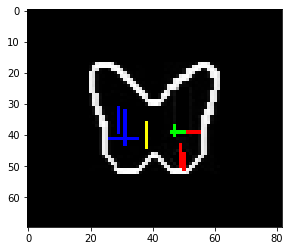

malignant


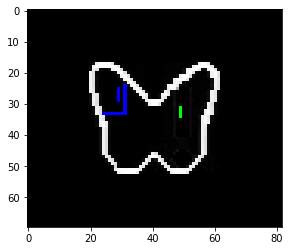

In [145]:
if len(df_nodule) >= 1:
    nod_intersect, nod_near = judge_intersect_near(df_nodule_probe)
    df_nodule_probe['cluster'] = pd.DataFrame(make_cluster(df_nodule_probe,nod_intersect, nod_near))
    print('nodule')
    show_cluster(df_nodule_probe,img_schema)

    
if len(df_malignant) >= 1:
    mal_intersect, mal_near = judge_intersect_near(df_malignant_probe)
    df_malignant_probe['cluster'] = pd.DataFrame(make_cluster(df_malignant_probe,mal_intersect, mal_near))
    print('malignant')
    show_cluster(df_malignant_probe,img_schema)

## 没(クラスターを円で表現)

In [ ]:
color_list = [(255,0,0),(0,255,0),(0,0,255),(0,255,255),(255,255,0),(255,0,255),(255,100,0)]

df_cluster = pd.DataFrame(columns = ['cluster','n_cluster','center(x,y)','sq_x','sq_y','image'])

img_schema_all = img_schema.copy()

n_cluster = len(set(list(df_nodule_probe['cluster'])))
for i in range(1,n_cluster+1):
    df_temp = df_nodule_probe[df_nodule_probe['cluster']==i].reset_index()
    
    img_schema_copy= np.uint8(np.zeros((sc.shape[0],sc.shape[1])))
    for j in range(len(df_temp)):
        nod_min = (df_temp['nod_min'][j][1], df_temp['nod_min'][j][0])
        nod_max = (df_temp['nod_max'][j][1], df_temp['nod_max'][j][0])
        cv2.line(img_schema_copy, nod_min, nod_max, color_list[i-1])
        cv2.line(img_schema_all, nod_min, nod_max, color_list[i-1])
        
    imgplot(img_schema_all)
    
    x_list=[]
    y_list=[]
    if len(df_temp) > 1:
        for j in range(len(df_temp)):
            min_y, min_x = df_temp['nod_min'][j]
            max_y, max_x = df_temp['nod_max'][j]
            x_list.append(min_x)
            x_list.append(max_x)
            y_list.append(min_y)
            y_list.append(max_y)
            
        x_sq = [min(x_list),min(y_list)]
        y_sq = [max(x_list),max(y_list)]
        center = [int((min(x_list)+max(x_list))/2) , int((min(y_list)+max(y_list))/2)]
        #x_sq, y_sq = [max(x_list)-min(x_list), max(y_list)-min(y_list)] 
        
    else:
        center = [int((df_temp['nod_min'][0][1] + df_temp['nod_max'][0][1])/2), int((df_temp['nod_min'][0][0] + df_temp['nod_max'][0][0])/2)] 
        x_sq = df_temp['nod_max'][0][1] - center[0]+1
        y_sq = df_temp['nod_max'][0][0] - center[1]+1
        
    if x_sq == 1:
        x_sq += 1
    if y_sq == 1:
        y_sq += 1
    df = pd.Series([i,len(df_temp), center, x_sq, y_sq,img_schema_copy], index = df_cluster.columns)
    df_cluster = df_cluster.append(df, ignore_index = True)

In [ ]:
for i in range(len(df_cluster)):
    if df_cluster['n_cluster'][i] == 1:
        cen_x, cen_y = df_cluster['center(x,y)'][i]
        cv2.ellipse(img_schema_all, box=((cen_x,cen_y),(df_cluster['sq_x'][i],df_cluster['sq_y'][i]), 0), color=color_list[i])
    else:
        cv2.rectangle(img_schema_all, tuple(df_cluster['sq_x'][0]),tuple(df_cluster['sq_y'][0]), color = color_list[i])
imgplot(img_schema_all)

In [ ]:
img = np.zeros(img_schema.shape, np.uint8)
img = np.uint8(cv2.cvtColor(img,cv2.COLOR_BGR2GRAY))
cv2.rectangle(img, tuple(df_cluster['sq_x'][0]),tuple(df_cluster['sq_y'][0]), 255)
img[df_cluster['sq_x'][0][1]+5,df_cluster['sq_x'][0][0]-1] = 255

contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print("{} contours.".format(len(contours)))

fig, ax = plt.subplots(figsize=(8, 8))
draw_contours(ax, img, contours)
plt.show()
    
contours.sort(key=cv2.contourArea, reverse=True)
cnt = contours[0]

imgplot(img)

ellipse = cv2.fitEllipse(cnt)
img2 = cv2.ellipse(img,ellipse,255)

imgplot(img2)